In [1]:
import os
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [12,12]
matplotlib.rcParams['figure.dpi'] = 200
from shapely.geometry import Polygon

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [4]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [5]:
train_inds = labeled_scene_index[:20]#np.random.choice(labeled_scene_index,20,replace=False)#labeled_scene_index[:20]#
val_inds = labeled_scene_index[20:]#np.array([i for i in labeled_scene_index if i not in train_inds])#labeled_scene_index[20:]#

In [6]:
train_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((288,288)),
                                            #torchvision.transforms.RandomAffine(degrees=0,translate=(0.1,0.1)),
                                            torchvision.transforms.ToTensor(),
                                           ])
#  torchvision.transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
#                                                                              std = [ 0.229, 0.224, 0.225 ])
#(mean = [ 0.485, 0.456, 0.406 ],std = [ 0.229, 0.224, 0.225 ])])
val_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((288,288)),
                                                torchvision.transforms.ToTensor(),])
# torchvision.transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
#                                             std = [ 0.229, 0.224, 0.225 ])

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_inds,
                                  transform=train_transform,
                                  extra_info=True
                                 )

labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_inds,
                                  transform=val_transform,
                                  extra_info=True
                                 )

trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [7]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([4, 6, 3, 288, 288])


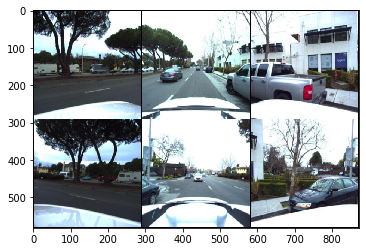

In [8]:
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0))

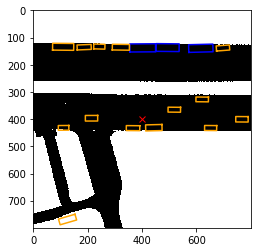

In [9]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary')
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])   

In [10]:
category_map = {'other_vehicle': 1, 'bicycle': 2, 'car': 3, 'pedestrian': 4, 'truck': 5,
                'bus': 6, 'motorcycle': 7, 'emergency_vehicle': 8, 'animal': 9}

## Model

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
class UNet(nn.Module):
    def ConvBlock(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, use_bias = False):
        block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, 
                                        stride, padding, bias = use_bias),
                              nn.BatchNorm2d(out_channels),
                              nn.ReLU(True)
                             )
        return block
    
    def Bridge(self, in_channels, out_channels):
        bridge = nn.Sequential(self.ConvBlock(in_channels, out_channels),
                               self.ConvBlock(out_channels, out_channels)
                              )
        return bridge
    
    def UpsampleBlock(self, in_channels, out_channels, use_bias=False):
        upsample = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(True))
        return upsample
        
    def UpsampleConv(self, in_channels, out_channels):
        upsample_conv = nn.Sequential(self.ConvBlock(in_channels, out_channels),
                                      self.ConvBlock(out_channels, out_channels))    
        return upsample_conv
        
        
    def __init__(self, num_classes, output_size, encoder='resnet18', pretrained = False, depth = 6):
        '''
        num_classes: Number of channels/classes for segmentation
        output_size: Final output size of the image (H*H)
        encoder: Supports resnet18, resnet 34 and resnet50 architectures
        pretrained: For loading a pretrained resnet model as encoder
        '''
        super(UNet,self).__init__()  
        self.depth = depth
        self.num_classes = num_classes
        self.output_size = output_size
        
        self.resnet = torchvision.models.resnet50(pretrained=pretrained) if encoder == "resnet50" else\
                            torchvision.models.resnet34(pretrained=pretrained) if encoder == "resnet34" else\
                            torchvision.models.resnet18(pretrained=pretrained)
        
        self.resnet_layers = list(self.resnet.children())
        self.n = 2048 if encoder == "resnet50" else 512
        
        self.input_block = nn.Sequential(*self.resnet_layers)[:3]
        self.input_block[0] = nn.Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.input_pool = self.resnet_layers[3]
        self.down_blocks = nn.ModuleList([i for i in self.resnet_layers if isinstance(i, nn.Sequential)])

        self.bridge = self.Bridge(self.n, self.n)
        
        self.up_blocks = nn.ModuleList([self.UpsampleBlock(self.n,self.n//2)[0],
                                        self.UpsampleBlock(self.n//2,self.n//4)[0],
                                        self.UpsampleBlock(self.n//4,self.n//8)[0],
                                        self.UpsampleBlock(self.n//8,self.n//16)[0],
                                        self.UpsampleBlock(self.n//16,self.n//32)[0]])
        
        self.up_conv = nn.ModuleList([self.UpsampleConv(self.n,self.n//2),
                                      self.UpsampleConv(self.n//2,self.n//4),
                                      self.UpsampleConv(self.n//4,self.n//8),
                                      self.UpsampleConv(self.n//16 + 64,self.n//16),
                                      self.UpsampleConv(self.n//32 + 18,self.n//32)])
        
        self.final_upsample_1 = self.UpsampleBlock(self.n//32,self.n//64)
        self.final_upsample_2 = self.UpsampleBlock(self.n//64,self.num_classes)[0]
        
        self.final_pooling = nn.AdaptiveMaxPool2d(output_size=self.output_size)

    def forward(self, x):
        skip_conn = {"layer_0": x}
        x = self.input_block(x)
        skip_conn[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i != (self.depth - 1):
                skip_conn[f"layer_{i}"] = x
            
        x = self.bridge(x)

        #x = torch.sum(x,dim=0)
        #x = x.repeat((6,1,1,1))

        for i, block in enumerate(self.up_blocks):
            key = f"layer_{self.depth - i - 2}"            
            x = block(x)
            x = torch.cat([x, skip_conn[key]],1)
            x = self.up_conv[i](x)

        del skip_conn
        
        #x = torch.sum(x,dim=0)
        x = self.final_upsample_1(x)#.unsqueeze(0))
        x = self.final_upsample_2(x)
        x = self.final_pooling(x)
        #x = x.view(-1,self.output_size,self.output_size)
        #x = torch.sigmoid(x)
        return x

In [13]:
class DetectionModel(nn.Module):
    def __init__(self):
        super(DetectionModel,self).__init__()
        self.encoder = UNet(num_classes=3, output_size=800, encoder="resnet34", pretrained = False).to(device)
        self.detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
        
    def forward(self,x,targets=None):
        if self.training:
            x = self.encoder(x)
            x = [i for i in x]
            x = self.detector(x, targets)
        else:
            with torch.no_grad():
                x = self.encoder(x)
                x = [i for i in x]
                x = self.detector(x)
        return x

In [15]:
lr = 5e-5
num_epochs = 20

In [16]:
model = DetectionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

### Training

In [18]:
def compute_iou(box1, box2):
    a = Polygon(torch.t(box1)).convex_hull
    b = Polygon(torch.t(box2)).convex_hull
    
    return a.intersection(b).area / a.union(b).area

def compute_ats_bounding_boxes(boxes1, boxes2):
    num_boxes1 = boxes1.size(0)
    num_boxes2 = boxes2.size(0)

    boxes1_max_x = boxes1[:, 0].max(dim=1)[0]
    boxes1_min_x = boxes1[:, 0].min(dim=1)[0]
    boxes1_max_y = boxes1[:, 1].max(dim=1)[0]
    boxes1_min_y = boxes1[:, 1].min(dim=1)[0]

    boxes2_max_x = boxes2[:, 0].max(dim=1)[0]
    boxes2_min_x = boxes2[:, 0].min(dim=1)[0]
    boxes2_max_y = boxes2[:, 1].max(dim=1)[0]
    boxes2_min_y = boxes2[:, 1].min(dim=1)[0]

    condition1_matrix = (boxes1_max_x.unsqueeze(1) > boxes2_min_x.unsqueeze(0))
    condition2_matrix = (boxes1_min_x.unsqueeze(1) < boxes2_max_x.unsqueeze(0))
    condition3_matrix = (boxes1_max_y.unsqueeze(1) > boxes2_min_y.unsqueeze(0))
    condition4_matrix = (boxes1_min_y.unsqueeze(1) < boxes2_max_y.unsqueeze(0))
    condition_matrix = condition1_matrix * condition2_matrix * condition3_matrix * condition4_matrix

    iou_matrix = torch.zeros(num_boxes1, num_boxes2)
    for i in range(num_boxes1):
        for j in range(num_boxes2):
            if condition_matrix[i][j]:
                iou_matrix[i][j] = compute_iou(boxes1[i], boxes2[j])

    iou_max = iou_matrix.max(dim=0)[0]

    iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    total_threat_score = 0
    total_weight = 0
    for threshold in iou_thresholds:
        tp = (iou_max > threshold).sum()
        threat_score = tp * 1.0 / (num_boxes1 + num_boxes2 - tp)
        total_threat_score += 1.0 / threshold * threat_score
        total_weight += 1.0 / threshold

    average_threat_score = total_threat_score / total_weight
    
    return average_threat_score

In [21]:
best_val_ts = 0
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for i, (sample, target, _, _) in enumerate(tqdm(trainloader)):  
        sample = torch.stack(sample).view(-1,18,288,288).to(device)
        targets = [{'boxes':torch.cat([t['bounding_box'][:,0].min(1)[0].view(-1,1)*10.0 + 400,t['bounding_box'][:,1].min(1)[0].view(-1,1)*10.0 + 400,t['bounding_box'][:,0].max(1)[0].view(-1,1)*10.0 + 400,t['bounding_box'][:,1].max(1)[0].view(-1,1)*10.0 + 400],dim=1).float().to(device),
                    'labels':torch.LongTensor(t['category']+1).to(device)} for t in target]
        
        optimizer.zero_grad()
        loss_dict = model(sample,targets)

        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        if (i+1)%200 == 0:
            print("Epoch: {} | Iter: {} | Train loss: {}".format(epoch+1, i+1, train_loss/(i+1)))
    
    model.eval()
    val_loss = 0
    val_ts = []
    with torch.no_grad():        
        for i, (sample, target, _, _) in enumerate(tqdm(valloader)):
            sample = torch.stack(sample).view(-1,18,288,288).to(device)
            targets = target[0]['bounding_box']
            out = model(sample)
            output = torch.transpose(out[0]['boxes'].view(-1,2,2),1,2).cpu()
            t = (output-400)/10.0
            cars = torch.zeros(t.shape[0],2,4)
            cars[:,0] = t[:,0].repeat(1,2)
            cars[:,1,:2] = t[:,1]
            cars[:,1,2:] = t[:,1].flip(1)
            val_ts.append(compute_ats_bounding_boxes(cars, targets).item())
        
    epoch_val_ts = np.mean(val_ts)
    print("Epoch: {} |  Val TS: {}".format(epoch+1, epoch_val_ts))
#     if epoch_val_ts>best_val_ts:
#         best_val_ts = epoch_val_ts
#         print("Saving model...")
#         torch.save(model.state_dict(),'unet_model_dropout.pth')
    #scheduler.step(epoch)

 32%|███▏      | 200/630 [01:17<02:44,  2.61it/s]

Epoch: 1 | Iter: 200 | Train loss: 1.2190834823250771


 63%|██████▎   | 400/630 [02:32<01:30,  2.53it/s]

Epoch: 1 | Iter: 400 | Train loss: 1.1405931931734086


 95%|█████████▌| 600/630 [03:48<00:11,  2.63it/s]

Epoch: 1 | Iter: 600 | Train loss: 1.110115192135175


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 1 |  Val TS: 0.0019609028145962854


 32%|███▏      | 200/630 [01:16<02:43,  2.63it/s]

Epoch: 2 | Iter: 200 | Train loss: 1.0121178798377515


 63%|██████▎   | 400/630 [02:32<01:29,  2.57it/s]

Epoch: 2 | Iter: 400 | Train loss: 0.9933228013664483


 95%|█████████▌| 600/630 [03:47<00:11,  2.66it/s]

Epoch: 2 | Iter: 600 | Train loss: 0.9902578311661879


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 2 |  Val TS: 0.010188922517016412


 32%|███▏      | 200/630 [01:18<02:39,  2.69it/s]

Epoch: 3 | Iter: 200 | Train loss: 0.9703422285616398


 63%|██████▎   | 400/630 [02:34<01:26,  2.66it/s]

Epoch: 3 | Iter: 400 | Train loss: 0.9700539976358413


 95%|█████████▌| 600/630 [03:50<00:11,  2.65it/s]

Epoch: 3 | Iter: 600 | Train loss: 0.9671951417128245


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 3 |  Val TS: 0.014819672867094003


 32%|███▏      | 200/630 [01:16<02:42,  2.65it/s]

Epoch: 4 | Iter: 200 | Train loss: 0.9208649434149265


 63%|██████▎   | 400/630 [02:32<01:25,  2.69it/s]

Epoch: 4 | Iter: 400 | Train loss: 0.9249672260135412


 95%|█████████▌| 600/630 [03:48<00:11,  2.68it/s]

Epoch: 4 | Iter: 600 | Train loss: 0.9228195021549861


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 4 |  Val TS: 0.01645294066411369


 32%|███▏      | 200/630 [01:16<02:42,  2.64it/s]

Epoch: 5 | Iter: 200 | Train loss: 0.8765573190152645


 63%|██████▎   | 400/630 [02:32<01:26,  2.67it/s]

Epoch: 5 | Iter: 400 | Train loss: 0.8760793326795101


 95%|█████████▌| 600/630 [03:48<00:11,  2.67it/s]

Epoch: 5 | Iter: 600 | Train loss: 0.8759357555210591


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 5 |  Val TS: 0.014272895628343418


 32%|███▏      | 200/630 [01:16<02:41,  2.66it/s]

Epoch: 6 | Iter: 200 | Train loss: 0.8585677538812161


 63%|██████▎   | 400/630 [02:32<01:27,  2.64it/s]

Epoch: 6 | Iter: 400 | Train loss: 0.8508266392350197


 95%|█████████▌| 600/630 [03:48<00:11,  2.67it/s]

Epoch: 6 | Iter: 600 | Train loss: 0.8458687383929888


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 6 |  Val TS: 0.014649609386059826


 32%|███▏      | 200/630 [01:17<02:53,  2.47it/s]

Epoch: 7 | Iter: 200 | Train loss: 0.8248341710865498


 57%|█████▋    | 362/630 [02:19<01:43,  2.59it/s]

KeyboardInterrupt: 

In [ ]:
#model.load_state_dict(torch.load('unet_model.pth'))

### Visualize predictions

In [43]:
model.eval()
sample, target, road_image, extra = iter(trainloader).next()
# sample, road_image = torch.stack(sample).view(-1,18,288,288).to(device), \
#                                 torch.stack(road_image).float().to(device)
out = model(torch.stack(sample).view(-1,18,288,288).to(device))
output = torch.transpose(out[0]['boxes'].view(-1,2,2),1,2).cpu()
t = (output-400)/10.0
cars = torch.zeros(t.shape[0],2,4)
cars[:,0] = t[:,0].repeat(1,2)
cars[:,1,:2] = t[:,1]
cars[:,1,2:] = t[:,1].flip(1)

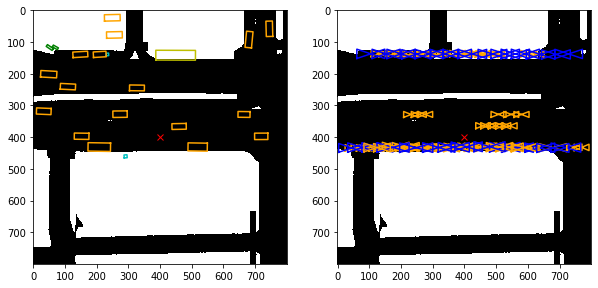

In [53]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax1.imshow(road_image[0], cmap ='binary')
ax1.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax1, bb, color=color_list[target[0]['category'][i]])   
    
ax2.imshow(road_image[0], cmap ='binary')
ax2.plot(400, 400, 'x', color="red")
for i, bb in enumerate(cars):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax2, bb,color=color_list[out[0]['labels'][i]-1])

In [54]:
model.eval()
sample, target, road_image, extra = iter(valloader).next()
# sample, road_image = torch.stack(sample).view(-1,18,288,288).to(device), \
#                                 torch.stack(road_image).float().to(device)
out = model(torch.stack(sample).view(-1,18,288,288).to(device))
output = torch.transpose(out[0]['boxes'].view(-1,2,2),1,2).cpu()
t = (output-400)/10.0
cars = torch.zeros(t.shape[0],2,4)
cars[:,0] = t[:,0].repeat(1,2)
cars[:,1,:2] = t[:,1]
cars[:,1,2:] = t[:,1].flip(1)

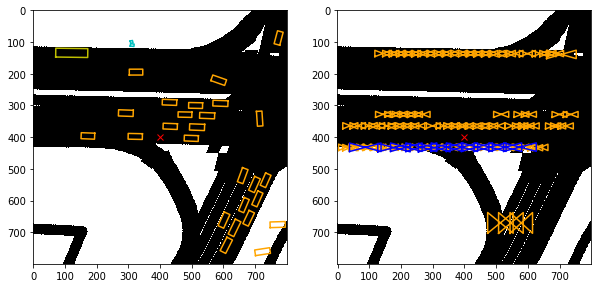

In [55]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax1.imshow(road_image[0], cmap ='binary')
ax1.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax1, bb, color=color_list[target[0]['category'][i]])   
    
ax2.imshow(road_image[0], cmap ='binary')
ax2.plot(400, 400, 'x', color="red")
for i, bb in enumerate(cars):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax2, bb,color=color_list[out[0]['labels'][i]-1])